In [2]:
%pip install torch torchvision Pillow pycocotools opencv-python azure-ai-ml matplotlib

  Using cached matplotlib-3.10.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached contourpy-1.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.58.5-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (106 kB)
  Using cached kiwisolver-1.4.8-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (6.2 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.6 MB)
Using cached contourpy-1.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (325 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.58.5-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (4.8 MB)
Using cached kiwisolver-1.4.8-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl

In [9]:
import os

def get_filenames_without_extension(folder_path, extension):
    return {os.path.splitext(f)[0] for f in os.listdir(folder_path) if f.endswith(extension)}

def find_mismatched_files(json_folder, jpg_folder):
    json_names = get_filenames_without_extension(json_folder, '.json')
    jpg_names = get_filenames_without_extension(jpg_folder, '.jpg')

    only_in_json = json_names - jpg_names
    only_in_jpg = jpg_names - json_names
    print(only_in_json)
    print(only_in_jpg)

    mismatched = sorted(list(only_in_json | only_in_jpg))
    return mismatched

json_folder = './data/annotations'
jpg_folder = './data/images'

mismatched_files = find_mismatched_files(json_folder, jpg_folder)

print("일치하지 않는 파일 이름:")
for name in mismatched_files:
    print(name)

set()
set()
일치하지 않는 파일 이름:


In [10]:
# scripts/prepare_frcnn_data.py
# Faster R-CNN 학습용 데이터 준비
import os, json, glob

# 원본 JSON 파일들이 있는 폴더
anno_dir = "./data/annotations"
coco_data = {
    "images": [], 
    "annotations": [], 
    # object type별 카테고리 정의 (정상/파손 구분 없이 객체 종류만 정의)
    "categories": [
        {"id": 1, "name": "PE드럼"}, {"id": 2, "name": "PE방호벽"},
        {"id": 3, "name": "PE안내봉"}, {"id": 4, "name": "라바콘"},
        {"id": 5, "name": "시선유도봉"}, {"id": 6, "name": "제설함"},
        {"id": 7, "name": "PE입간판"}, {"id": 8, "name": "PE휀스"}
    ]
}
image_id = 1
ann_id = 1

for json_file in glob.glob(os.path.join(anno_dir, "*.json")):
    data = json.load(open(json_file, 'r', encoding='utf-8'))
    img_info = data["images"][0]
    # 이미지 정보 업데이트 (id 재할당)
    img_info["id"] = image_id
    img_info.pop("licence", None); img_info.pop("url", None)
    coco_data["images"].append(img_info)
    for ann in data["annotations"]:
        # 카테고리를 상태 구분 없이 객체 타입으로 매핑
        old_cat = ann["category_id"]
        new_cat = (old_cat + 1) // 2  # (1,2->1; 3,4->2; ... 15,16->8)
        ann["category_id"] = new_cat
        ann["image_id"] = image_id
        ann["id"] = ann_id
        coco_data["annotations"].append({
            "id": ann_id,
            "image_id": image_id,
            "category_id": new_cat,
            "bbox": ann["bbox"],
            "area": ann["area"],
            "iscrowd": ann["iscrowd"]
        })
        ann_id += 1
    image_id += 1

# 최종 COCO JSON 저장
with open("./data/instances.json", "w", encoding="utf-8") as f:
    json.dump(coco_data, f, ensure_ascii=False, indent=2)
print("COCO 포맷 JSON 생성 완료. 총 이미지:", image_id-1)

COCO 포맷 JSON 생성 완료. 총 이미지: 16368


In [3]:
# scripts/prepare_resnet_data.py
# ResNet50 분류용 데이터 준비
import os
import glob
import json
from PIL import Image

# 원본 이미지와 라벨 경로 설정
img_dir = "./data/images"
anno_dir = "./data/annotations"
save_root = "./classification_data"

# 저장 폴더 생성
os.makedirs(os.path.join(save_root, "정상"), exist_ok=True)
os.makedirs(os.path.join(save_root, "파손"), exist_ok=True)

# 모든 라벨 파일에 대해 반복
for json_path in glob.glob(os.path.join(anno_dir, "*.json")):
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    image_info = data["images"][0]
    image_filename = image_info["file_name"]
    image_path = os.path.join(img_dir, image_filename)

    # 이미지 열기
    try:
        image = Image.open(image_path).convert("RGB")
    except FileNotFoundError:
        print(f"이미지 파일 없음: {image_path}")
        continue

    # 각 annotation에 대해 crop 및 저장
    for ann in data["annotations"]:
        category_id = ann["category_id"]
        bbox = ann["bbox"]  # [x, y, w, h]
        x, y, w, h = map(int, bbox)
        crop = image.crop((x, y, x + w, y + h))

        # category_id 기준으로 정상/파손 판단
        label = "정상" if category_id % 2 == 1 else "파손"

        # 저장 파일명 구성
        image_base = os.path.splitext(image_filename)[0]
        ann_id = ann["id"]
        save_path = os.path.join(save_root, label, f"{image_base}_{ann_id}.jpg")
        crop.save(save_path)

print("ResNet50 분류용 crop 이미지 생성 완료")

ResNet50 분류용 crop 이미지 생성 완료


In [1]:
# Faster R-CNN용 데이터 샘플링 (부분 데이터셋 생성)
from pycocotools.coco import COCO
import random, json

# 원본 COCO 어노테이션 로드
coco = COCO("./data/instances.json")
all_img_ids = coco.getImgIds()

# 랜덤으로 이미지 ID 3000개 추출
subset_ids = random.sample(all_img_ids, 3000)

# 선택된 이미지 정보 리스트 생성
images = [coco.loadImgs(id)[0] for id in subset_ids]

# 선택된 이미지별 어노테이션 추출
anns = []
for img in images:
    ann_ids = coco.getAnnIds(imgIds=img["id"])
    anns.extend(coco.loadAnns(ann_ids))

# 부분 데이터셋 COCO 형식 JSON 생성
coco_subset = {
    "images": images,
    "annotations": anns,
    "categories": coco.dataset["categories"]
}
with open("./data/instances_subset.json", "w") as f:
    json.dump(coco_subset, f, ensure_ascii=False, indent=2)


loading annotations into memory...
Done (t=0.26s)
creating index...
index created!


In [1]:
# COCO Dataset 클래스 구현
import os
import torch
from PIL import Image
from torch.utils.data import Dataset
from pycocotools.coco import COCO

class COCODetectionDataset(Dataset):
    def __init__(self, image_dir, annotation_path, transforms=None):
        self.image_dir = image_dir
        self.coco = COCO(annotation_path)
        self.image_ids = list(self.coco.imgs.keys())
        self.transforms = transforms

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img_info = self.coco.loadImgs(image_id)[0]
        img_path = os.path.join(self.image_dir, img_info["file_name"])
        image = Image.open(img_path).convert("RGB")

        ann_ids = self.coco.getAnnIds(imgIds=[image_id])
        annotations = self.coco.loadAnns(ann_ids)

        boxes = []
        labels = []
        areas = []
        iscrowd = []

        for ann in annotations:
            x, y, w, h = ann["bbox"]
            # COCO의 [x,y,width,height] -> [xmin, ymin, xmax, ymax]
            boxes.append([x, y, x+w, y+h])
            labels.append(ann["category_id"])
            areas.append(ann["area"])
            iscrowd.append(ann.get("iscrowd", 0))

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        areas = torch.tensor(areas, dtype=torch.float32)
        iscrowd = torch.tensor(iscrowd, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([image_id]),
            "area": areas,
            "iscrowd": iscrowd
        }

        if self.transforms:
            image = self.transforms(image)

        return image, target

In [3]:
# 학습 설정 및 훈련 코드
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 학습/검증 데이터셋 및 데이터로더 준비
train_dataset = COCODetectionDataset("./data/images", "./data/instances.json", transforms=ToTensor())
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)), num_workers=8)

# 미리 학습된 Faster R-CNN 모델 로드 (COCO 클래스 수로 초기화 후 교체)
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
num_classes = 1 + len(train_dataset.coco.cats)  # (배경 포함)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
num_epochs = 15
len_train_loader = len(train_loader)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    i = 0
        
    for images, targets in train_loader:
        i += 1

        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        total_loss += losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        print(f"{i} / {len_train_loader}...")

    print(f"[Epoch {epoch+1}/{num_epochs}] Loss: {total_loss:.4f}")

# 모델 저장
torch.save(model.state_dict(), "./outputs/fasterrcnn_model.pt")
print("모델 저장 완료: fasterrcnn_model.pt")

loading annotations into memory...
Done (t=0.30s)
creating index...
index created!
1 / 4092...
2 / 4092...
3 / 4092...
4 / 4092...
5 / 4092...
6 / 4092...
7 / 4092...
8 / 4092...
9 / 4092...
10 / 4092...
11 / 4092...
12 / 4092...
13 / 4092...
14 / 4092...
15 / 4092...
16 / 4092...
17 / 4092...
18 / 4092...
19 / 4092...
20 / 4092...
21 / 4092...
22 / 4092...
23 / 4092...
24 / 4092...
25 / 4092...
26 / 4092...
27 / 4092...
28 / 4092...
29 / 4092...
30 / 4092...
31 / 4092...
32 / 4092...
33 / 4092...
34 / 4092...
35 / 4092...
36 / 4092...
37 / 4092...
38 / 4092...
39 / 4092...
40 / 4092...
41 / 4092...
42 / 4092...
43 / 4092...
44 / 4092...
45 / 4092...
46 / 4092...
47 / 4092...
48 / 4092...
49 / 4092...
50 / 4092...
51 / 4092...
52 / 4092...
53 / 4092...
54 / 4092...
55 / 4092...
56 / 4092...
57 / 4092...
58 / 4092...
59 / 4092...
60 / 4092...
61 / 4092...
62 / 4092...
63 / 4092...
64 / 4092...
65 / 4092...
66 / 4092...
67 / 4092...
68 / 4092...
69 / 4092...
70 / 4092...
71 / 4092...
72 

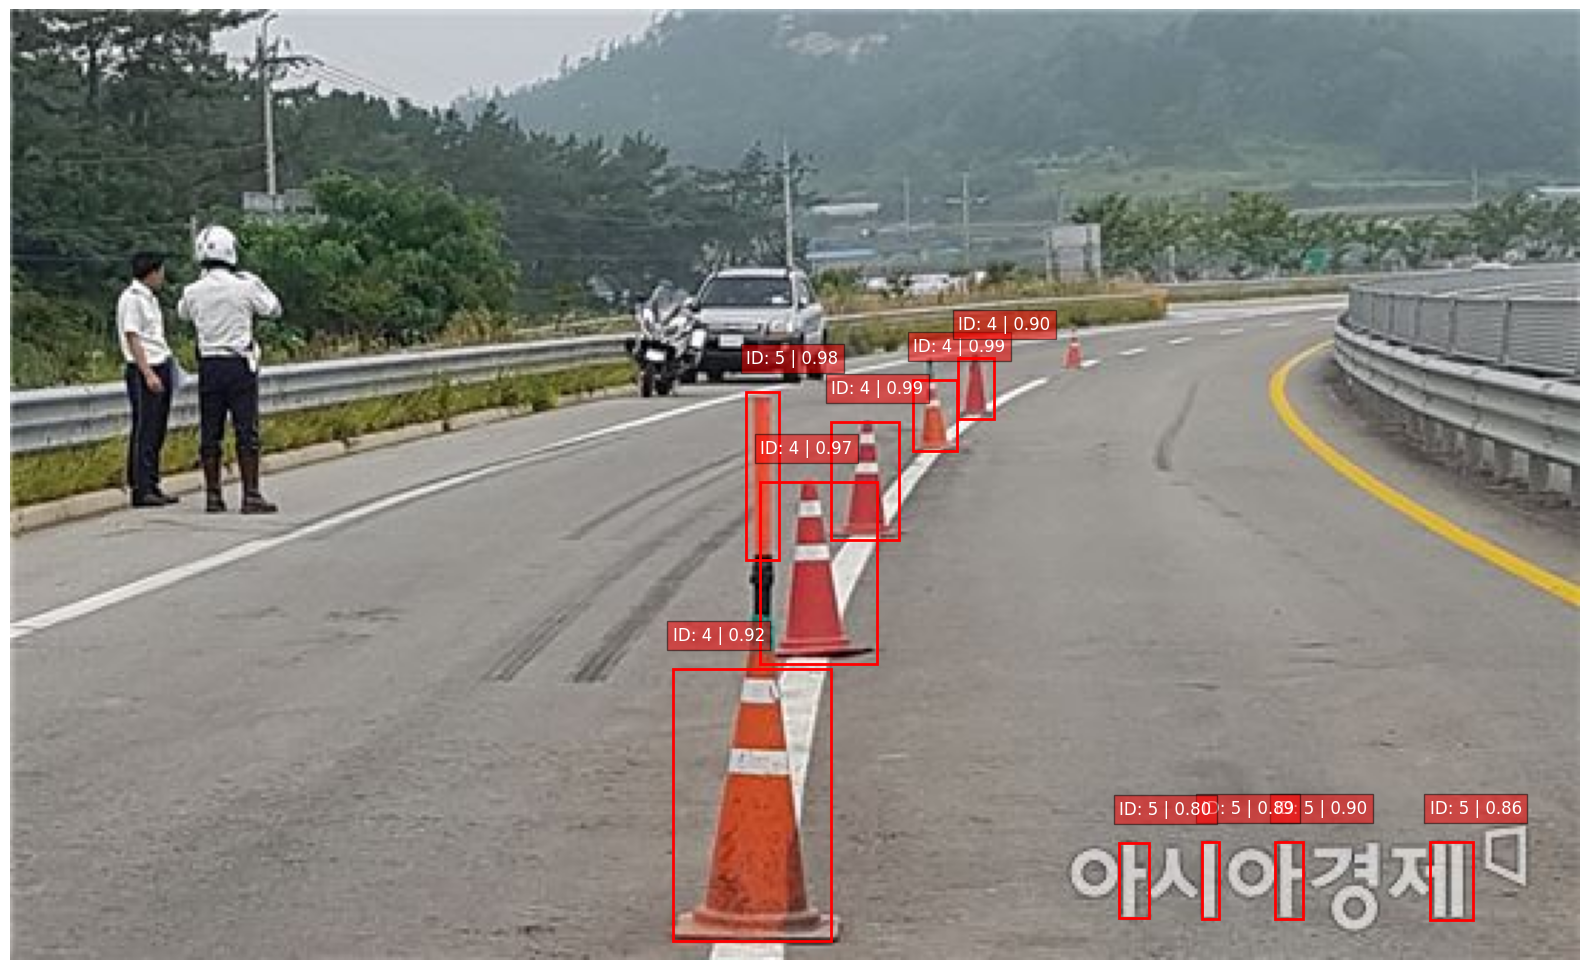

In [4]:
import torch
import torchvision
from torchvision.transforms import ToTensor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 1. 이미지 선택
image_path = "./test4.jpg"
image = Image.open(image_path).convert("RGB")

# 2. 전처리: Tensor로 변환
transform = ToTensor()
img_tensor = transform(image).unsqueeze(0)  # [1, 3, H, W] 형태로 배치 차원 추가

# 3. 모델 로드 및 설정
device = torch.device("cpu")
model = fasterrcnn_resnet50_fpn(weights="DEFAULT")
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 9)

model.load_state_dict(torch.load('./models/fasterrcnn_model.pt', map_location=device))
model.to(device)
model.eval()

# 4. 추론
with torch.no_grad():
    outputs = model(img_tensor.to(device))

# 5. 출력 결과 확인
output = outputs[0]
boxes = output["boxes"]
labels = output["labels"]
scores = output["scores"]

# 6. 시각화: confidence threshold 이상만 표시
threshold = 0.5

fig, ax = plt.subplots(1, figsize=(16, 10))
ax.imshow(image)

for box, label, score in zip(boxes, labels, scores):
    if score >= threshold:
        x1, y1, x2, y2 = box
        width = x2 - x1
        height = y2 - y1
        rect = patches.Rectangle(
            (x1, y1), width, height,
            linewidth=2, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)
        ax.text(
            x1, y1 - 10,
            f"ID: {label.item()} | {score:.2f}",
            color='white',
            fontsize=12,
            bbox=dict(facecolor='red', alpha=0.5)
        )

plt.axis("off")
plt.tight_layout()
plt.show()